In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import torch
from src.Default_Torch_WaveNet import Wave
from omegaconf import OmegaConf
from dataset_utils.SigSepDataset import SigSepDataset
# from dataset_utils import generate_competition_eval_mixture
from torch.utils.data import DataLoader
import numpy as np
# from torchsummary import summary

import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [4]:
# generate some test data
soi_type = "QPSK"
interference_type = "CommSignal3"

batch_size = 8
num_batches = 1000
dataset_path = "rf_datasets/train_test_set_unmixed/dataset/testset1_frame"

# dataset_path = generate_competition_eval_mixture(soi_type, dataset_path)

In [5]:
# dataset = SigSepDataset(dataset_dir=dataset_path, dtype="real")
dataset = SigSepDataset(
    dataset_dir="rf_datasets/test_set_mixed/datasets/eval_QPSK_20240401_180404", dtype="real")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
batch = next(iter(loader))
soi_mix, soi_target, msg_bits, intrf_type, sinr_db = batch
soi_mix.shape, soi_target.shape, msg_bits.shape, intrf_type.shape, sinr_db.shape

(torch.Size([8, 2, 40960]),
 torch.Size([8, 2, 40960]),
 torch.Size([8, 5120]),
 torch.Size([8]),
 torch.Size([8]))

In [7]:
cfg = OmegaConf.load("src/configs/wavenet.yaml")
model = Wave(cfg.model).to(device)
# summary(model, input_size=soi_mix.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 40960]             384
            Conv1d-2           [-1, 256, 40960]          98,560
            Conv1d-3           [-1, 256, 40960]          33,024
     ResidualBlock-4  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-5           [-1, 256, 40960]          98,560
            Conv1d-6           [-1, 256, 40960]          33,024
     ResidualBlock-7  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-8           [-1, 256, 40960]          98,560
            Conv1d-9           [-1, 256, 40960]          33,024
    ResidualBlock-10  [[-1, 128, 40960], [-1, 128, 40960]]               0
           Conv1d-11           [-1, 256, 40960]          98,560
           Conv1d-12           [-1, 256, 40960]          33,024
    ResidualBlock-13  [[-1, 128, 40960], [-1, 128, 40960]]            

In [8]:
# load weights
loaded_model = torch.load(
    "torchmodels/dataset_qpsk_commsignal3_mixture_wavenet/weights-206000.pt")
# loaded_model = torch.load("torchmodels/dataset_qpsk_commsignal2_mixture_wavenet/weights.pt")
print(loaded_model.keys())
model.load_state_dict(loaded_model["model"])

dict_keys(['step', 'model', 'optimizer', 'cfg', 'scaler'])


<All keys matched successfully>

In [9]:
intrf_files = ['CommSignal2', 'CommSignal3', 'CommSignal5G1', 'EMISignal1']
model.eval()

sinr_all = []
soi_target = []
msg_bits_all = []
soi_no_mitigation = []
soi_est = []

for i, batch in enumerate(loader):
    # if i == 3:
    #     break
    sample_soi_mix, sample_soi_target, msg_bits, intrf_type, sinr_db = batch
    idx = intrf_files.index(interference_type)
    sample_soi_mix, sample_soi_target = sample_soi_mix[intrf_type == idx].to(
        device), sample_soi_target[intrf_type == idx].to(device)
    sinr_db = sinr_db[intrf_type == idx]
    msg_bits = msg_bits[intrf_type == idx]

    sample_soi_hat = model(sample_soi_mix)

    soi_target.extend(sample_soi_target.cpu().detach().numpy())
    sinr_all.extend(sinr_db.numpy())
    msg_bits_all.extend(msg_bits.numpy())
    soi_no_mitigation.extend(sample_soi_mix.cpu().detach().numpy())
    soi_est.extend(sample_soi_hat.cpu().detach().numpy())

soi_target = np.array(soi_target)
sinr_all = np.array(sinr_all)
msg_bits_all = np.array(msg_bits_all)
soi_no_mitigation = np.array(soi_no_mitigation)
soi_est = np.array(soi_est)
soi_target.shape, sinr_all.shape, msg_bits_all.shape, soi_no_mitigation.shape, soi_est.shape

((1100, 2, 40960), (1100,), (1100, 5120), (1100, 2, 40960), (1100, 2, 40960))

In [10]:
from comm_utils import qpsk_helper, ofdm_helper

2024-04-01 18:40:01.192861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 18:40:01.192923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 18:40:01.193865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 18:40:01.199078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 18:40:03.015161: I tensorflow/core/common_

In [11]:
# combine IQ parts
soi_no_mitigation = soi_no_mitigation[:,
                                      0, :] + 1j * soi_no_mitigation[:, 1, :]
soi_target = soi_target[:, 0, :] + 1j * soi_target[:, 1, :]
soi_est = soi_est[:, 0, :] + 1j * soi_est[:, 1, :]
print(soi_target.shape, soi_no_mitigation.shape, soi_est.shape)
bit_no_mitigation, _ = qpsk_helper.demodulate_qpsk_signal(soi_no_mitigation)
bit_est, _ = qpsk_helper.demodulate_qpsk_signal(soi_est)

(1100, 40960) (1100, 40960) (1100, 40960)


2024-04-01 18:40:03.492729: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-01 18:40:03.833840: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-01 18:40:03.901709: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
def get_db(p): return 10*np.log10(p)
def get_pow(s): return np.mean(np.abs(s)**2, axis=-1)
def get_sinr(s, i): return get_pow(s)/get_pow(i)


def get_sinr_db(s, i): return get_db(get_sinr(s, i))

In [13]:
# evaluate the mse
mse_no_mitigation = get_db(
    np.mean(np.abs(msg_bits_all - bit_no_mitigation)**2, axis=-1))
mse_wavenet = get_db(np.mean(np.abs(msg_bits_all - bit_est)**2, axis=-1))

/tmp/ipykernel_63242/3807040701.py:1: RuntimeWarning: divide by zero encountered in log10
  def get_db(p): return 10*np.log10(p)


In [14]:
# evaluate the bit error rate
ber_no_mitigation = np.mean(
    bit_no_mitigation != msg_bits_all, axis=-1).astype(np.float32)
ber_wavenet = np.mean(
    bit_est != msg_bits_all, axis=-1).astype(np.float32)
print(f"{'Examples':<10} {'BER (No Mitigation)':<20} {'BER (WaveNet)':<20} {'SINR':<10}")
count = 0
for i, (ber1, ber2) in enumerate(zip(ber_no_mitigation, ber_wavenet)):
    if ber1 <= 1e-2 or ber2 <= 1e-2:  # only print if the BER is significant
        print(
            f"{i + 1:<10} {ber1:<20.10f} {ber2:<20.10f} {sinr_all[i]:<10.2f}")
        count += 1
        if count == 10:
            break

Examples   BER (No Mitigation)  BER (WaveNet)        SINR      
2          0.0058593750         0.0000000000         -0.23     
3          0.0408203118         0.0005859375         -3.27     
5          0.0072265626         0.0000000000         -0.23     
6          0.0464843735         0.0003906250         -3.26     
9          0.0058593750         0.0013671875         -0.28     
13         0.0058593750         0.0050781248         -0.24     
20         0.0064453124         0.0066406252         -0.24     
40         0.1011718735         0.0076171877         -6.22     
41         0.0054687499         0.0048828125         -0.20     
46         0.0431640632         0.0000000000         -3.22     


In [15]:
def get_smoothed(sinr, ber, npoints=50):
    bins = np.linspace(sinr.min(), sinr.max(), npoints)
    bin_means, bin_edges, _ = binned_statistic(
        sinr, ber, statistic='mean', bins=bins)

    # To plot the line at the center of the bins, calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, bin_means

Text(0, 0.5, 'BER')

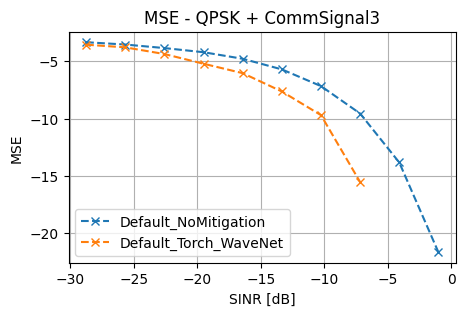

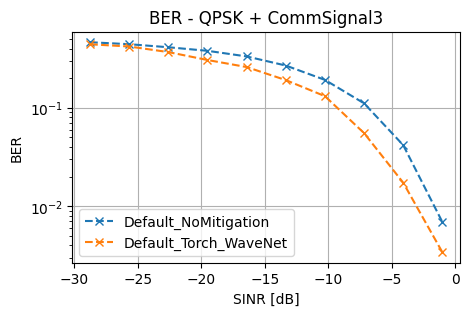

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(*get_smoothed(sinr_all, mse_no_mitigation,
         11), "x--", label="Default_NoMitigation")
plt.plot(*get_smoothed(sinr_all, mse_wavenet,
         11), "x--", label="Default_Torch_WaveNet")
plt.grid()
plt.legend()
plt.title(f"MSE - {soi_type} + {interference_type}")
plt.xlabel("SINR [dB]")
plt.ylabel("MSE")

plt.figure(figsize=(5, 3))
plt.semilogy(*get_smoothed(sinr_all, ber_no_mitigation,
             11), "x--", label="Default_NoMitigation")
plt.semilogy(*get_smoothed(sinr_all, ber_wavenet,
             11), "x--", label="Default_Torch_WaveNet")
plt.grid()
plt.legend()
plt.title(f"BER - {soi_type} + {interference_type}")
plt.xlabel("SINR [dB]")
plt.ylabel("BER")